In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import statsmodels.api as sm

In [6]:
import seaborn as sns

In [7]:
from scipy import stats

In [8]:
from scipy import signal

In [9]:
%matplotlib inline

In [10]:
####################################
#--       INPUT VARIABLES       
####################################
data_input_dir = "02_data/input/"
data_intermediate_dir = "02_data/intermediate/"
data_output_dir = "02_data/output/"
models_prod_dir = "03_models/prod/"
models_archive_dir = "03_models/archive/"
#-- Change to project directory
path = 'C:/Users/Mohamed Ibrahim/Box Sync/FX_DATASCIENCE/main_fx'
import os
#-- Change to project home directory
os.chdir(path)
exec(open("01_code/prod/P1_functions.py").read())


In [11]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

In [12]:
def fracDiff(series,d,thres=.01):
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue # exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [13]:
df = pd.read_csv(data_input_dir+"dt_all_min.csv")

In [14]:
df.head()

,Time,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD,Open_USDJPY,High_USDJPY,Low_USDJPY,Close_USDJPY,Open_GBPUSD,...,Low_NZDUSD,Close_NZDUSD,Open_AUDUSD,High_AUDUSD,Low_AUDUSD,Close_AUDUSD,Open_XAUUSD,High_XAUUSD,Low_XAUUSD,Close_XAUUSD
0,2004-06-01 00:00:00,1.21912,1.21931,1.21899,1.21931,109.45,109.46,109.45,109.45,1.83274,...,0.63280,0.63280,0.7157,0.7158,0.7157,0.7157,394.873,394.873,394.873,394.873
1,2004-06-01 00:01:00,1.21909,1.21943,1.21909,1.21938,109.42,109.45,109.39,109.42,1.83243,...,0.63295,0.63295,0.7157,0.7161,0.7157,0.7161,394.873,394.873,394.873,394.873
2,2004-06-01 00:02:00,1.21913,1.21945,1.21912,1.21913,109.43,109.47,109.41,109.41,1.83310,...,0.63288,0.63330,0.7161,0.7161,0.7157,0.7157,394.873,394.873,394.873,394.873
3,2004-06-01 00:03:00,1.21920,1.21937,1.21909,1.21937,109.41,109.44,109.40,109.41,1.83285,...,0.63335,0.63345,0.7157,0.7160,0.7157,0.7159,394.873,394.873,394.873,394.873
4,2004-06-01 00:04:00,1.21926,1.21944,1.21918,1.21930,109.43,109.45,109.39,109.39,1.83261,...,0.63307,0.63338,0.7161,0.7163,0.7159,0.7162,394.873,394.873,394.873,394.873


In [15]:
from statsmodels.tsa.stattools import adfuller

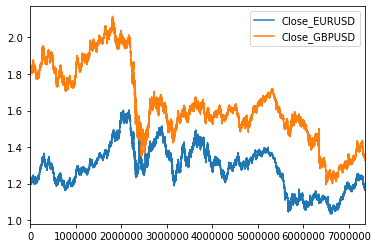

In [16]:
df[['Close_EURUSD','Close_GBPUSD']].plot.line()

In [17]:
dd = df[['Time','Open_EURUSD','High_EURUSD','Low_EURUSD','Close_EURUSD']]

In [18]:
dd['Time'] = pd.to_datetime(dd['Time'])

C:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
dd.set_index('Time', inplace=True)

In [20]:
dd.head()

,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD
Time,,,,
2004-06-01 00:00:00,1.21912,1.21931,1.21899,1.21931
2004-06-01 00:01:00,1.21909,1.21943,1.21909,1.21938
2004-06-01 00:02:00,1.21913,1.21945,1.21912,1.21913
2004-06-01 00:03:00,1.21920,1.21937,1.21909,1.21937
2004-06-01 00:04:00,1.21926,1.21944,1.21918,1.21930


In [21]:
dd = dd.resample('B').agg({'Open_EURUSD': 'first','High_EURUSD': 'max', 
                                         'Low_EURUSD': 'min', 
                                         'Close_EURUSD': 'last'})

In [22]:
dd.head()

,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD
Time,,,,
2004-06-01,1.21912,1.22657,1.21543,1.22396
2004-06-02,1.22385,1.23030,1.22030,1.22093
2004-06-03,1.22067,1.22496,1.21680,1.22137
2004-06-04,1.22170,1.22997,1.21395,1.22939
2004-06-07,1.22980,1.23373,1.22885,1.23134


In [23]:
dd['ret'] = dd['Close_EURUSD']-dd['Close_EURUSD'].shift(2)

In [24]:
dd.head()

,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD,ret
Time,,,,,
2004-06-01,1.21912,1.22657,1.21543,1.22396,NaN
2004-06-02,1.22385,1.23030,1.22030,1.22093,NaN
2004-06-03,1.22067,1.22496,1.21680,1.22137,-0.00259
2004-06-04,1.22170,1.22997,1.21395,1.22939,0.00846
2004-06-07,1.22980,1.23373,1.22885,1.23134,0.00997


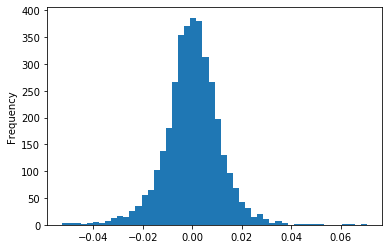

In [25]:
dd['ret'].plot.hist(bins=50)

In [26]:
adfuller(dd['ret'].dropna())

(-10.31034736886769,
 3.197554197197998e-18,
 30,
 3616,
 {'1%': -3.432159720193857,
  '5%': -2.862339633287972,
  '10%': -2.56719565730786},
 -24418.946773078893)

In [27]:
stats.normaltest(dd['Close_EURUSD'].dropna())

NormaltestResult(statistic=42.42300663024574, pvalue=6.137071136899303e-10)

In [28]:
b = getWeights(0.5,3)

In [29]:
b

array([[-0.125],
       [-0.5  ],
       [ 1.   ]])

In [56]:
w, h = signal.freqz(getWeights(1,2))

C:\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


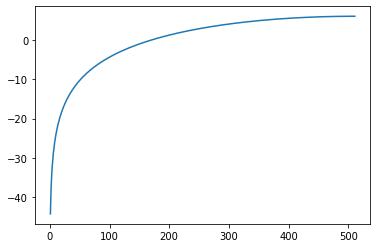

In [57]:
plt.plot(20 * np.log10(abs(h)))

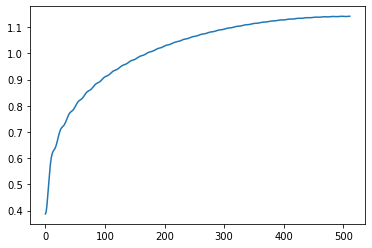

In [32]:
plt.plot(abs(h))

In [35]:
np.reshape(getWeights(0.9,5).T, (5,))

array([-0.0086625, -0.0165   , -0.045    , -0.9      ,  1.       ])

In [ ]:
np.roots(np.reshape(getWeights(0.9,50).T, (50,)))

In [82]:
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams

def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 3; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    

    return z, p, k

In [ ]:
N=6
r=0.1
zplane(np.reshape(getWeights(r,N).T, (N,)), a=1)

In [74]:
def plotTFs(f1,f2):
    w, h1 = signal.freqz(f1)
    w, h2 = signal.freqz(f2)
    axes = plt.gca()
#axes.set_xlim([xmin,xmax])
    axes.set_ylim([-10,5])
    plt.plot(20*np.log10(abs(h1)),'r--',20*np.log10(abs(h2)),'b--')

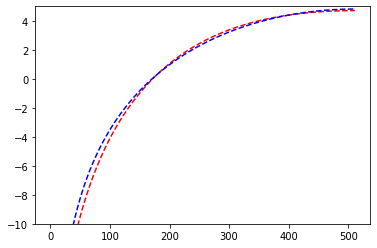

In [96]:
r1 = 0.8
N1 = 3
r2 = 0.8
N2 = 300
plotTFs(np.reshape(getWeights(r1,N1).T, (N1,)),np.reshape(getWeights(r2,N2).T, (N2,)))


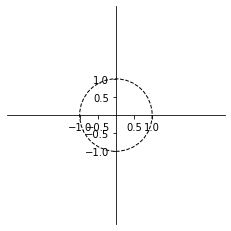

(array([-5.95433216,  3.73210994]), array([], dtype=float64), 1.0)

In [87]:
zplane(np.reshape(getWeights(r2,N2).T, (N2,)), a=1)